## 🌡️ Daily Average Temperature Forecasting using LSTM

This notebook presents a deep learning approach to forecast the daily average temperature using a Long Short-Term Memory (LSTM) network.

We follow these main steps:
- Load and preprocess historical temperature data
- Normalize the time series
- Prepare the data for supervised learning
- Train an LSTM model
- Evaluate and visualize the predictions

The dataset covers daily average temperatures in **New York City** from January 2000 to December 2024, retrieved using the Meteostat library.

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Warnings
import warnings
warnings.filterwarnings('ignore')

## 📥 Step 1: Load and Prepare the Dataset

We load the historical daily average temperature data, clean and format it, and set the `Time` column as the index for time series analysis.

In [290]:
df = pd.read_csv('../data/new_york_daily_avg_temp_2005_2025.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9133 entries, 0 to 9132
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    9133 non-null   object 
 1   tavg    9133 non-null   float64
dtypes: float64(1), object(1)
memory usage: 142.8+ KB


In [291]:
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df.set_index('time', inplace=True)
# df = df[df['tavg'] != 0.0]  # Drop rows with 0.0 values after conversion
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9133 entries, 2000-01-01 to 2025-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    9133 non-null   float64
dtypes: float64(1)
memory usage: 142.7 KB


,tavg
time,
2000-01-01,5.0
2000-01-02,9.4
2000-01-03,14.4
2000-01-04,14.4
2000-01-05,3.9
2000-01-06,1.1
2000-01-07,5.6
2000-01-08,1.1
2000-01-09,6.1


## 🔍 Step 2: Explore the Dataset

Let's check the structure and summary statistics of the daily average temperature data to understand it better.

In [292]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9133 entries, 2000-01-01 to 2025-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    9133 non-null   float64
dtypes: float64(1)
memory usage: 142.7 KB


,tavg
count,9133.000000
mean,13.530789
std,9.553821
min,-17.800000
25%,5.800000
50%,13.800000
75%,22.200000
max,35.800000


## ⚖️ Step 3: Normalize the Data

To improve LSTM performance, we normalize the daily average temperature values using MinMaxScaler to scale them into the [0, 1] range.

In [293]:
# Initialize the scaler to normalize data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the daily average temperature data
data_scaled = scaler.fit_transform(df['tavg'].values.reshape(-1, 1))

# Show the first 5 scaled values
print(data_scaled[:5])

[[0.42537313]
 [0.50746269]
 [0.60074627]
 [0.60074627]
 [0.40485075]]


## ✂️ Step 4: Train-Test Split

We divide the normalized daily average temperature data into 90% training and 10% testing sets to evaluate the model’s performance on unseen data.

In [294]:
train_size = int(len(data_scaled) * 0.90)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

print(f"Training data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 8219
Test data size: 914


## 🔁 Step 5: Create Input Sequences

We use a sliding window technique to generate input/output pairs for the LSTM model.
Here, we use `look_back = 30` , meaning the model will use the past 30 days’ daily average temperatures to predict the next day’s temperature.

In [295]:
def get_data(data, look_back):
    """
    Create input-output sequences for LSTM training.
    
    Parameters:
    - data: normalized time series data (numpy array)
    - look_back: number of previous time steps to use as input
    
    Returns:
    - datax: input sequences
    - datay: corresponding output values
    """
    datax, datay = [], []
    for i in range(len(data) - look_back - 1):
        datax.append(data[i:(i + look_back), 0])
        datay.append(data[i + look_back, 0])
    return np.array(datax), np.array(datay)

In [296]:
look_back = 30
x_train, y_train = get_data(train_data, look_back)
x_test, y_test = get_data(test_data, look_back)

## 🔄 Step 6: Reshape Data

We reshape the input sequences to match the LSTM model’s expected input shape: `(samples, time_steps, features)`.

In [ ]:
x_train = x_train.reshape(x_train.shape[0], look_back, 1)
x_test = x_test.reshape(x_test.shape[0], look_back, 1)

## 🧠 Step 7: Build the LSTM Model

We build a simple yet powerful LSTM model with:
- 150 units
- ReLu activation
- Dropout for regularization to reduce overfitting

In [ ]:
model = Sequential()
model.add(LSTM(150, activation='relu',  input_shape=(look_back, 1)))
model.add(Dense(1, activation='linear'))
model.add(Dropout(0.0002))
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           151 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

## ⚙️ Step 8: Compile and Train the Model

We use the Adam optimizer and Mean Squared Error (MSE) as the loss function.  
Training incorporates EarlyStopping to prevent overfitting and improve generalization.

In [299]:
# Compile the LSTM model with Adam optimizer and MSE loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model with early stopping to prevent overfitting
model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
    )

Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - loss: 0.0438 - val_loss: 0.0038
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - loss: 0.0045 - val_loss: 0.0030
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 9/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 10/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 11/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 12/50
256/256 ━━━━━━━━━━

## 🔍 Step 9: Make Predictions and Invert Scaling

After training, we predict daily average temperatures on the test set and invert the normalization to interpret the results in actual temperature units.

In [300]:
# Predict daily average temperatures on the test set
y_pred = model.predict(x_test)

# Invert scaling to get predictions back to original temperature units
y_pred = scaler.inverse_transform(y_pred)

# Reshape y_test and invert its scaling for comparison
y_test = np.array(y_test).reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)

# Display first 10 predicted and actual values
print("Predicted temperatures (first 10):", y_pred[:10].flatten())
print("Actual temperatures (first 10):", y_test[:10].flatten())

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Predicted temperatures (first 10): [24.25659  27.344152 25.03189  27.603405 26.622282 27.831799 27.536701
 28.524841 29.347599 26.292284]
Actual temperatures (first 10): [26.7 25.7 27.4 27.5 28.3 28.5 29.4 30.7 27.6 26.7]


## 📊 Step 10: Visualize Results

We plot the actual vs predicted daily average temperatures to visually evaluate the performance of our LSTM model.

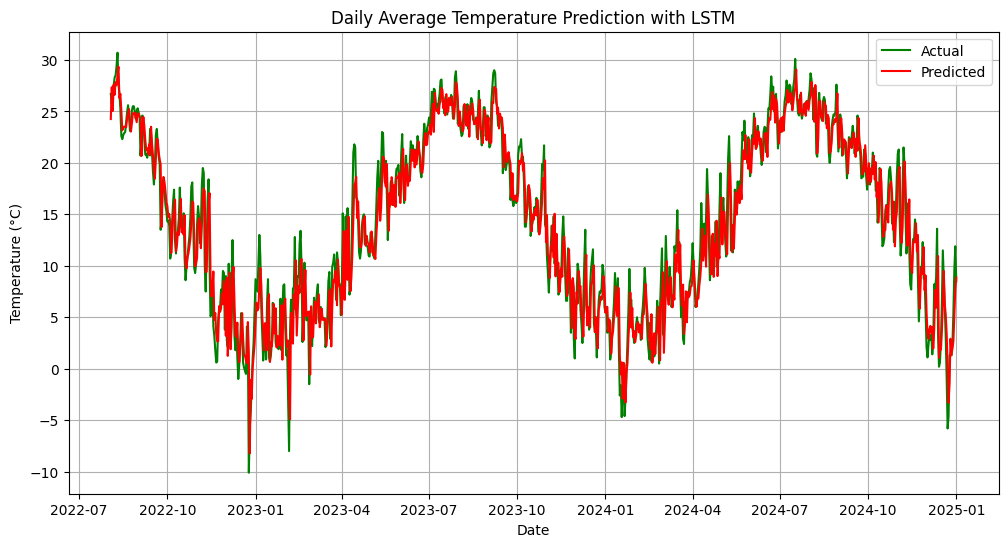

In [301]:
plt.figure(figsize=(12, 6))

# Plot actual temperatures
plt.plot(df.index[-len(y_test):], y_test, label="Actual", color='g')

# Plot predicted temperatures
plt.plot(df.index[-len(y_test):], y_pred, label="Predicted", color='r')

plt.title("Daily Average Temperature Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

## 📐 Step 11: Evaluate Model Performance

We compute the following evaluation metrics:
- MAE (Mean Absolute Error)
- MSE (Mean Squared Error)
- RMSE (Root Mean Squared Error)
- R² (The R-squared score)
- Precision = R² * 100

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape
r2 = r2_score(y_test, y_pred)
precision = r2 * 100

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'The R-squared score (R²): {r2:.4f}')
print(f'Precision: {precision:.2f}%')

Mean Absolute Error (MAE): 1.8307
Mean Squared Error (MSE): 5.7049
Root Mean Squared Error (RMSE): 2.3885
The R-squared score (R²): 0.9195
Precision: 91.95%
